# Training

Here I will trian the CNN to predict different skin conditions in the images.

First import neccessary libraries 

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.models import load_model # type: ignore
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Set up some comstants including, the test, and train directories, image constants and batch size.

In [27]:
# Directories 
TRAIN_DIR = '/Users/michelangelozampieri/Desktop/AJL_MIT/bttai-ajl-2025-no-augm/train/train'
TEST_DIR = '/Users/michelangelozampieri/Desktop/AJL_MIT/bttai-ajl-2025-no-augm/test/test'

# Define image size and batch size
IMG_SIZE = (244, 244)
BATCH_SIZE = 32

Get all categories and remove .DS_STORE

In [28]:
# Get a list of all categories (subdirectories) in TRAIN_DIR
categories = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]

# Remove hidden files like .DS_Store
categories = [c for c in categories if not c.startswith(".")]

# Get a list of all categories (subdirectories) in TRAIN_DIR
categories = [entry.name for entry in os.scandir(TRAIN_DIR) if entry.is_dir()]

print(categories)

['dyshidrotic-eczema', 'acne-vulgaris', 'acne', 'dermatomyositis', 'eczema', 'melanoma', 'basal-cell-carcinoma-morpheiform', 'malignant-melanoma', 'keloid', 'epidermal-nevus', 'squamous-cell-carcinoma', 'seborrheic-keratosis', 'basal-cell-carcinoma', 'mycosis-fungoides', 'kaposi-sarcoma', 'pyogenic-granuloma', 'actinic-keratosis', 'folliculitis', 'dermatofibroma', 'prurigo-nodularis', 'superficial-spreading-melanoma-ssm']


Now I create a test_datagen which is what will be used for training, this will create tensor of images that the model will use for training. 

Rescale the images by ividing the pixels by 255 and saving 20% for validation. 

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Randomly apply shearing transformations
    zoom_range=0.2,  # Randomly zoom in/out on images
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in missing pixels after transformations
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [30]:
# Data preprocessing 
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    classes=[category for category in categories]
)

Found 2860 images belonging to 21 classes.


- TRAIN_DIR - Points to the training directory where the images are 
- target_size = IMG_SIZE - Ensures all images are a constant size
- batch_size = BATCH_SIZE - Generates constant batch sizes
- class_mode="categorical" - Ensures that the classes are one-hot-encoded since there are many
- classes=[]- Labels are the categories

Similarly we create a validation datagen to validate the model during training

In [34]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels=None,  # No labels inferred
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 1227 files.


We will start with EfficientNetB0 and modify it 

In [32]:
from tensorflow.keras.applications import EfficientNetB0 # type: ignore
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization # type: ignore
from tensorflow.keras.models import Model # type: ignore

# Step 2: Load EfficientNetB0 and Modify It
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(244, 244, 3))
base_model.trainable = False  # Initially freeze the base model

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)  # Reduce feature maps to a single vector
x = Dense(64, activation="relu")(x)  # Fewer neurons for simplicity
x = BatchNormalization()(x)  # Optional: Stabilize training
output_layer = Dense(train_generator.num_classes, activation="softmax")(x)  # Output layer

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

Start compliling the model in an inital step

In [33]:
# Step 3: Compile and Train (Feature Extraction Phase)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train for a few epochs with frozen base model
EPOCHS_INITIAL = 5

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_INITIAL
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
45/90 ━━━━━━━━━━━━━━━━━━━━ 17:16 23s/step - accuracy: 0.0578 - loss: 3.1551

KeyboardInterrupt: 

Optimize the model and fine tune it

In [ ]:
# Step 4: Fine-Tune the Model (Unfreeze Base Layers)
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

# Use a lower learning rate for fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

# Recompile model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Train again with fine-tuning
EPOCHS_FINE_TUNE = 10

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_FINE_TUNE
)

Epoch 1/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1553s 4s/step - accuracy: 0.0906 - loss: 3.1757 - val_accuracy: 0.1114 - val_loss: 2.9176
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1945s 5s/step - accuracy: 0.1846 - loss: 2.7361 - val_accuracy: 0.1956 - val_loss: 2.6957
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1514s 4s/step - accuracy: 0.2380 - loss: 2.5720 - val_accuracy: 0.2880 - val_loss: 2.4161
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 3883s 9s/step - accuracy: 0.2888 - loss: 2.4223 - val_accuracy: 0.2617 - val_loss: 2.5268
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1608s 4s/step - accuracy: 0.3296 - loss: 2.2728 - val_accuracy: 0.3371 - val_loss: 2.2474
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1700s 4s/step - accuracy: 0.3711 - loss: 2.1216 - val_accuracy: 0.3667 - val_loss: 2.1419
Epoch 7/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1854s 4s/step - accuracy: 0.4159 - loss: 1.9591 - val_accuracy: 0.3444 - val_loss: 2.2284
Epoch 8/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 1937s 5s/step - accuracy: 0.4554 - loss: 1.8325 - 

See training history and plot it

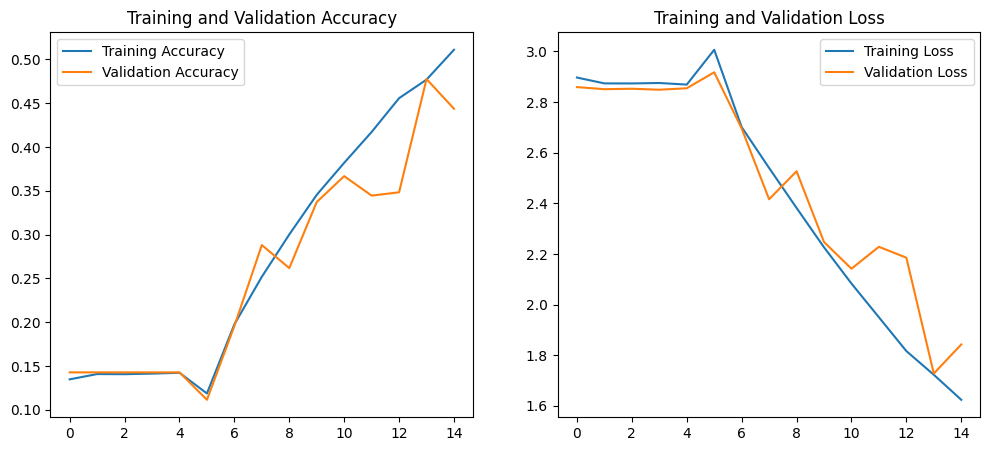

In [ ]:
# Step 6: Plot Training Curves
def plot_training_curves(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title("Training and Validation Accuracy")

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.show()

plot_training_curves(history, history_fine)

Save the model to an exteranl file for easier reuse later

In [ ]:
model.save('my_model_v2.h5')

Here I had to restart my computer so I reloaded the model

In [5]:
# Load the saved model
MODEL_PATH = "/Users/michelangelozampieri/Desktop/AJL_MIT/MIT-AJL-Team1/my_model.h5"
model = load_model(MODEL_PATH)

# Verify that the model is loaded
model.summary()

NameError: name 'load_model' is not defined

Now we start making predictions. 

First create a test_datagen, similarly it creates batches of normalized images for the model to make predictions on. I will do this by first making a dataframe to store all image hashes and using that to make the test_gen

In [ ]:
# Get all image filenames
test_images = [f for f in os.listdir(TEST_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Create a DataFrame with file paths
test_df = pd.DataFrame({"md5hash": test_images})
print(test_df.head())  # Check the first few entries

                                md5hash
0  9a7c1451aa6d667b5b4dc11e243f40f5.jpg
1  a5a355561aa62dd374d3bd2e52926d66.jpg
2  0fd4f7d195dd7b1355d2389d8b2ed1dc.jpg
3  97e6abb7e279b5ca10f72deb36e3f50d.jpg
4  d740f99aa0236f9972d66f0821cf14b0.jpg


In [ ]:
# Define ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Load test images using flow_from_dataframe()
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=TEST_DIR,  # Base directory for test images
    x_col="md5hash",  # Column with image filenames
    target_size=(244, 244),
    batch_size=32,
    class_mode=None,  # No labels, since it's test data
    shuffle=False  # Keep order for predictions
)

Found 1227 validated image filenames.


In [ ]:
# Define the generator wrapper
def test_generator_wrapper(generator):
    for batch in generator:
        yield (batch,)

# Create the dataset from the generator
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator_wrapper(test_generator),
    output_signature=(tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),)
)

Now we actually make predictions

In [ ]:
# Predict on test images
predictions = model.predict(test_dataset)

# Convert softmax probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Get class labels from the training generator
class_labels = list(train_generator.class_indices.keys())

# Map predictions to class names
predicted_labels = [class_labels[i] for i in predicted_classes]

# Add predictions to DataFrame
test_df["label"] = predicted_labels

# Show results
print(test_df.head())

  22954/Unknown 18914s 824ms/step

Save them to a csv file to be save

In [ ]:
# Remove ".jpg" extension from filenames
test_df["md5hash"] = test_df["md5hash"].str.replace(".jpg", "")

In [ ]:
test_df.to_csv('predictions.csv', index=False)